<a href="https://colab.research.google.com/github/Jaesu26/Dacon-Basic/blob/main/%EC%9D%8C%EC%84%B1-%EB%B6%84%EB%A5%98-DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 음성 분류 경진대회

`-` 참고: https://dacon.io/competitions/official/235905/codeshare/5138?page=1&dtype=recent

## 데이터 불러오기

In [83]:
# !pip install adabelief-pytorch

In [1]:
import librosa
import librosa.display as dsp
from IPython.display import Audio
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from glob import glob

warnings.filterwarnings('ignore')

In [2]:
sns.set_theme(style='white')

In [80]:
SEED = 22
N_FOLD = 5
SAVE_PATH = './weight4'
LEARNING_RATE = 1e-7
EPOCHS = 200
BATCH_SIZE = 32

In [4]:
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd '/content/drive/MyDrive/Colab Notebooks/음성-분류'

/content/drive/MyDrive/Colab Notebooks/음성-분류


In [6]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [7]:
df.head()

,file_name,label
0,001.wav,9
1,002.wav,0
2,004.wav,1
3,005.wav,8
4,006.wav,0


`-` 파일명과 라벨(0~9까지의 음성)이 한 쌍으로 되어있다

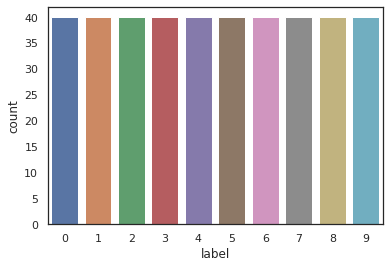

In [8]:
sns.countplot(data=df, x='label')

`-` 0~9의 숫자가 균일하게 40개씩 분포 되어있다

## WAV 파일 EDA

### 오디오 시각화

`-` 음성 파일로부터 0~9까지 데이터를 하나씩 추출하여 소리를 들어보자

In [9]:
def get_audio(num=0):
    ## Audio Sample Directory
    sample = os.listdir('./Data/train/')
    temp = df[df.label == num].file_name ## df는 train.csv file
    file_name = temp[temp.index[0]]
    
    file = 'Data/train/' + file_name
    ## Get Audio from the location
    data, sample_rate = librosa.load(file)
    
    ## Plot the audio wave
    dsp.waveshow(data, sr=sample_rate)
    plt.show()
    
    ## Show the widget
    return Audio(data=data, rate=sample_rate)

- 숫자 0(zero) ~ 9(nine)의 음성

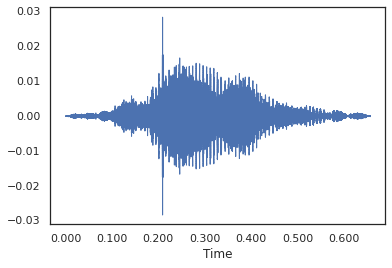

In [10]:
get_audio(0)

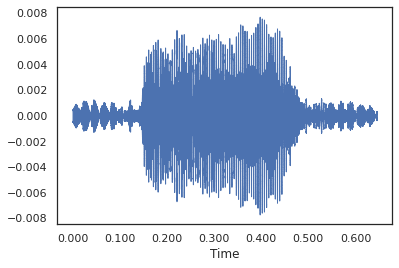

In [11]:
get_audio(1)

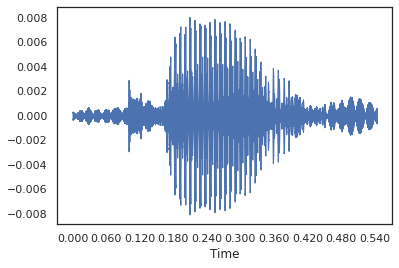

In [12]:
get_audio(2)

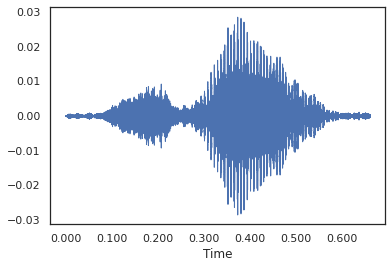

In [13]:
get_audio(3)

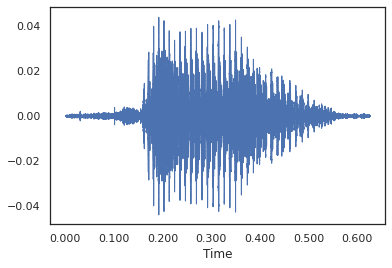

In [14]:
get_audio(4)

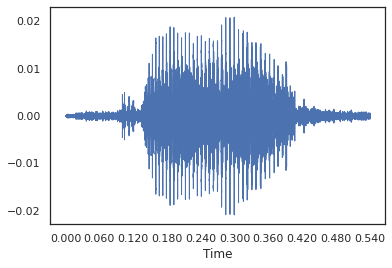

In [15]:
get_audio(5)

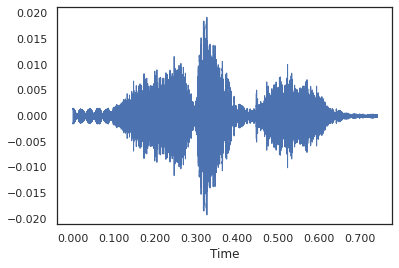

In [16]:
get_audio(6)

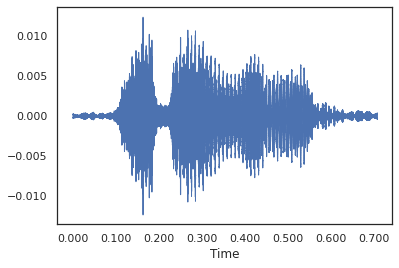

In [17]:
get_audio(7)

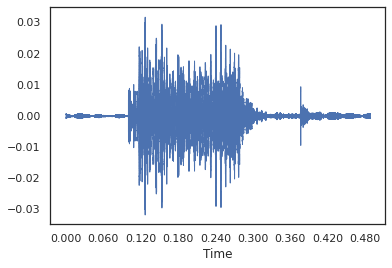

In [18]:
get_audio(8)

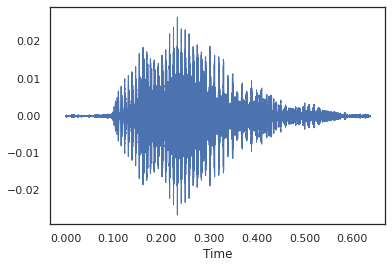

In [19]:
get_audio(9)

## 데이터 전처리

## 음성 데이터 Load

`-` sampling rate의 defult값은 22050Hz

`-` 사람의 목소리는 대부분 16000Hz 안에 포함되므로 16000으로 설정

`-` sampling rate의 의미는 초당 16000개(16000Hz 주파수)의 샘플을 가지고 있는 데이터라는 의미(1초에 음성 신호를 16000번 sampling)

`-` 즉, 1초짜리 영상을 16000 등분하여 샘플링한 것(값이 커질수록 간격이 더 작아짐)

`-` 등분을 너무 작게하면(=간격을 너무 크게하면) 음성을 구분하기 힘들것이고 반대로 간격을 너무 작게하면 cost 낭비임

In [20]:
def load_data(df: pd.DataFrame, path: str, sr: int = 16000):
    """df는 오디오 파일명과 라벨명을 컬럼으로 가지는 데이터프레임"""
    dataset = []
    is_train = 'label' in df ## df에 label이 존재하면 train, 존재하지 않으면 test
    for file in tqdm(df.file_name):
        audio, sr = librosa.load(path + file, sr=sr)
        if is_train: ## df에 label이 존재하면(=train)
            label = df.query('file_name == @file').label.item()
            dataset.append([audio, label])
        else: ## test
            dataset.append([audio])
    
    columns = ['audio', 'label'] if is_train else ['audio']
    return pd.DataFrame(dataset, columns=columns)

In [21]:
sr = 16000

In [22]:
train_wav = load_data(df, path='./Data/train/', sr=sr)
test_wav = load_data(test, path='./Data/test/', sr=sr)

100%|██████████| 200/200 [00:06<00:00, 32.07it/s]


### 음성 길이 padding

In [23]:
audio_len = train_wav['audio'].apply(lambda x: len(x) / sr) ## 샘플링 기준은 (sr) Hz, 음성 단위는 s(초)

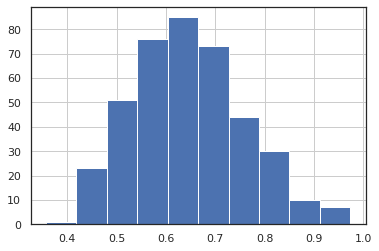

In [24]:
audio_len.hist() 

`-` 음성의 길이는 대개 0.6~0.7초이며 최소 길이는 0.35초, 최대 길이는 0.97초이다

`-` 모델을 훈련시킬려면 음성의 길이가 모두 동일해야 한다

`-` 음성 끝부분에 silence를 추가하여 음성 길이(Hz)를 동일하게 맞춰주자

In [25]:
def pad_audio(audio, pad_len: int) -> list:
    """음성 끝부분에 silence를 추가하여 음성 길이(Hz)를 동일하게 맞춰줌"""
    audio = list(audio) ## list type으로 변경
    audio_len = len(audio)
    if audio_len < pad_len:
        silence = [0] * (pad_len - audio_len)
        return audio + silence ## audio 끝부분에 silence 추가하여 padding
    return audio[:pad_len]

In [26]:
train_wav['pad_audio'] = train_wav['audio'].apply(lambda audio: np.array(pad_audio(audio, pad_len=sr))) ## mfcc와 mel-spectrogram을 얻기위해 넘파이 어레이로 변경
test_wav['pad_audio'] = test_wav['audio'].apply(lambda audio: np.array(pad_audio(audio, pad_len=sr))) 

### 음성 데이터 특징 추출¶

`-` 음성 raw data를 그대로 사용하면 파라미터가 너무 많아지기도 하고 데이터 용량이 너무 커진다

`-` 푸리에 변환을 통해 입력 신호를 다양한 주파수를 가지는 주기함수( sin,cos )들로 분해하자

`-` 주기함수들을 분해함으로써 음성 데이터에서 노이즈 및 배경 소리로 부터 실제로 유용한 소리의 데이터, 즉 특징을 추출

#### Mel-scale

`-` Mel은 사람의 달팽이관을 모티브로 따온 값

`-` 달팽이관은 주파수가 낮은 대역에서는 변화하는 주파수를 잘 감지하는데 주파수가 높은 대역에서는 주파수 감지를 잘 하지 못함 (주파수 간격이 넓어짐)

`-` 따라서 특징벡터로 그냥 주파수를 쓰기 보다는 달팽이관의 특성에 맞춰서 특징을 뽑아주는 것이 더욱 효과적일 것임

#### MFCC (Mel-frequency cepstral coefficients)

`-` 음성데이터 전체를 퓨리에 변환을 한다면, 예컨대 "안녕하세요"라고 하더라도 어떤 사람은 1초, 어떤 사람은 3초가 걸릴 수도 있음

`-` 따라서 이 천차만별인 길이에 대하여 같은 "안녕하세요"라는 음성이라고 학습시키기는 어려움

`-` 위와 같은 문제를 해결하기 위하여 MFCC (Mel-frequency cepstral coefficients) 알고리즘을 이용!

`-` 입력된 소리 전체를 대상으로 하는 것이 아니라 사람이 인지하기 좋은 Mel-scale로 음성데이터를 모두 20~40ms로 나누어 이 구간에 대한 스펙트럼을 분석하여 퓨리에 변환을 한 특징을 추출

`-` 사람의 음성은 20~40ms 사이에서는 음소(현재 내고 있는 발음)가 바뀔 수 없다는 연구결과들을 기반으로 음소는 해당 시간내에 바뀔 수 없다고 가정

`-` 따라서 MFCC에서는 음성데이터를 모두 20~40ms 단위로 쪼개고 쪼갠 단위에 대해서 Mel 값을 뽑아서 Feature로 사용

`-` 퓨리에 변환을 통과한 신호를 위의 Mel-filter Bank를 통과하게 되면 Mel-Spectrogram 이라는 피쳐가 뽑힘

`-` Mel-Spectrogram이라는 피쳐에 대해 행렬을 압축해서 표현해주는 DCT 연산을 수행하면 MFCC이다

`-` Mel-Spectrogram의 경우 주파수끼리 Correlate하기 때문에 도메인이 한정적인 문제에서 더 좋은 성능을 보임

`-` MFCC의 경우는 De-Correlate를 해주기 때문에 일반적인 상황에서 더 좋은 성능을 보임

In [27]:
def min_max_scale(x: np.array):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [28]:
def get_melspectrogram(audio: np.array, sr: int = 16000, n_mels: int = 32):
    mel_spec = librosa.feature.melspectrogram(audio, sr=sr, n_mels=n_mels) ## n_mels은 return 될  Mel-Spectrogram의 개수
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max) ## Mel-Spectrogram -> decibel units ## 10 * log10(S / np.max(S))
    mel_spec = min_max_scale(mel_spec) ## audio마다 단위를 맞춰주기 위함
    return mel_spec

In [29]:
def get_mfcc(audio: np.array, sr: int = 16000, n_mfcc: int = 32):
    mfcc = librosa.feature.mfcc(audio, sr=sr, n_mfcc=n_mfcc) ## n_mfcc은 return 될  MFCC의 개수
    mfcc = min_max_scale(mfcc) ## audio마다 단위를 맞춰주기 위함
    return mfcc

In [30]:
## train
train_wav['mel_spec'] = train_wav['pad_audio'].apply(lambda x: get_melspectrogram(x))
train_wav['mfcc'] = train_wav['pad_audio'].apply(lambda x: get_mfcc(x))

## test
test_wav['mel_spec'] = test_wav['pad_audio'].apply(lambda x: get_melspectrogram(x))
test_wav['mfcc'] = test_wav['pad_audio'].apply(lambda x: get_mfcc(x))

## 데이터 셋 및 딥러닝 모델 정의

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch import nn
from adabelief_pytorch import AdaBelief
import gc

- 가중치 저장 폴더 생성

In [32]:
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError as error:
        print(error)

In [33]:
create_folder(SAVE_PATH)

In [34]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [37]:
def seed_everything(seed: int = 22):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [38]:
seed_everything(SEED) ## 재현을 위한 seed 고정

- 데이터 셋

In [39]:
class CustomDataset(Dataset):
  
    def __init__(self, audios: np.array, label_list, train_mode=True, transforms=None):
        self.audios = audios
        self.label_list = label_list
        self.transforms = transforms
        self.train_mode = train_mode
    
    def __getitem__(self, idx):
        audio = torch.tensor(self.audios[idx]) ## numpy array를 tensor로 변환    
        if self.transforms is not None:
            audio = self.transforms(audio)
            
        if self.train_mode:
            label = self.label_list[idx]
            return audio, label
        
        return audio ## test는 라벨이 없다
    
    def __len__(self):
        return len(self.audios) ## 데이터 개수 반환

- CNN 모델

`-` CNN으로 오디오의 특징을 추출하여 분류

In [64]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=False) 
        self.drop = nn.Dropout(0.2)
        self.fc = nn.Linear(1000, 10) 
        
    def forward(self, x):
        x = self.model(x)
        x = self.drop(x)
        x = self.fc(x)
        return x

- 가중치 초기화

In [43]:
## layer 가중치 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0, np.sqrt(1 / y))
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

- 조기 중단

In [55]:
class EarlyStopping:
    ## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', n_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint 저장 경로
                            Default: 'checkpoint.pt'
            n_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = None
        self.delta = delta
        self.path = path
        self.n_fold = n_fold

    def __call__(self, model, val_loss, val_acc):

        score = -val_loss ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: ## loss가 개선되지 않았을 때
            self.counter += 1 ## 카운팅 +1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: ## loss가 개선됨
            self.best_score = score ## score 갱신
            self.save_checkpoint(val_loss, val_acc, model) ## loss와 model 저장
            self.counter = 0 ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/best_{self.n_fold}.pt') ## 모델의 계층별 가중치를 지정한 경로에 저장
        self.val_loss_min = val_loss ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc ## 이때의 valid accuracy도 변경해준다

- 스케쥴러

In [54]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    ## 코드: https://github.com/gaussian37/pytorch_deep_learning_models/blob/master/cosine_annealing_with_warmup/cosine_annealing_with_warmup.py
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
            
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

## 모델 교차검증

In [44]:
from sklearn.model_selection import StratifiedKFold

In [81]:
skfold = StratifiedKFold(n_splits=N_FOLD, random_state=SEED, shuffle=True) ## k겹 교차검증

In [46]:
loss_fn = nn.CrossEntropyLoss()

In [47]:
def train(model: nn.Module, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 epoch 하나당 batch들의 평균 훈련 오차를 반환"""
    model.train() ## 훈련모드
    train_avg_loss = 0 ## 에폭별 배치단위 평균 훈련 오차
    train_total_batch = len(dataloader) ## 배치 크기

    for X, y in dataloader: ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() ## 그래디언트 초기화
        yhat = model(X) ## y_hat을 구한다
        loss = loss_fn(yhat, y).to(device) ## 오차를 계산 ## train loss
        loss.backward()  ## 미분
        optimizer.step() ## 업데이트
        train_avg_loss += (loss.item() / train_total_batch) ## 각 배치마다 훈련 오차 누적

    ## epoch마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_avg_loss

In [48]:
def evaluate(model: nn.Module, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 모델에 대한 epoch 하나당 batch들의 평균 평가 오차와 평가 정확도를 반환"""
    valid_avg_acc, valid_avg_loss = 0, 0

    model.eval() ## 평가모드
    with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
        for X, y in dataloader: 
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y) ## valid loss
            acc = accuracy(y.cpu().data.numpy(), yhat.cpu().data.numpy().argmax(-1))       
            valid_avg_acc += (acc * len(y) / len(dataloader.dataset)) ## 각 배치마다 정확도(정답 개수 / 전체 개수)
            valid_avg_loss += loss.item() / len(dataloader) ## 각 배치마다 평가 오차 누적    

    return valid_avg_loss, valid_avg_acc

In [49]:
def show_loss_plot(train_loss: list, valid_loss: list, ax) -> None:
    epochs = len(train_loss)
    ax.set_title('Train Loss and Valid Loss')
    ax.plot(range(1, epochs+1), train_loss, label='Train')
    ax.plot(range(1, epochs+1), valid_loss, label='Valid')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

In [50]:
target = train_wav['label']

- Mel Spectrogram

In [51]:
train_melspec = torch.tensor(train_wav['mel_spec'])
test_melspec = torch.tensor(test_wav['mel_spec'])

In [52]:
## Resnet의 input 차원과 맞춰주고자 (Size X 3 X H X W)로 차원을 변환
train_melspec = train_melspec.reshape(-1, 1, 32, 32)
train_melspec = torch.cat([train_melspec, train_melspec, train_melspec], dim = 1).float()

test_melspec = test_melspec.reshape(-1, 1, 32, 32)
test_melspec = torch.cat([test_melspec, test_melspec, test_melspec], dim = 1).float()

In [103]:
## Mel Spectrogram
seed_everything(SEED) ## 정확한 loss 재현을 위함
net_avg_acc = [] ## fold별 valid셋의 평균 정확도
net_avg_loss = [] ## fold별 valid셋의 평균 손실
net_epoch_train_loss = [[] for _ in range(N_FOLD)] ## fold별 train셋의 한 epoch당 valid셋의 배치 평균 손실
net_epoch_valid_loss = [[] for _ in range(N_FOLD)] ## fold별 valid셋의 한 epoch당 valid셋의 배치 평균 손실

for i, (train_idx, valid_idx) in enumerate(skfold.split(train_melspec, target)):
    gc.collect()
    torch.cuda.empty_cache()
    print(f'[{i + 1} / {N_FOLD}] Fold Training......')
    
    X_train, X_valid = train_melspec[train_idx], train_melspec[valid_idx] 
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    
    ## early stopping
    early_stopping = EarlyStopping(patience=50,
                                  verbose=False,
                                  path=SAVE_PATH,
                                  n_fold=i+1) ## patience 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단
    
    ## CNN 모델
    net = Net().to(device)
    net.apply(weights_init) ## layer 가중치 초기화
    
    ## Dataset, Dataloader
    train_dataset = CustomDataset(X_train, y_train, train_mode=True, transforms=None)
    valid_dataset = CustomDataset(X_valid, y_valid, train_mode=True, transforms=None)
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

    ## optimizer
    optimizer = torch.optim.AdamW(net.parameters(), lr=LEARNING_RATE,) ## 옵티마이저에 최적화할 파라미터와 학습률 전달
                          
    ## scheduler  
    scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=30, T_mult=1, eta_max=1e-3, T_up=5, gamma=0.5)
    
    ## fold별로 모델 학습
    for epoch in tqdm(range(EPOCHS)): ## (배치사이즈 * 에폭)만큼 훈련시킴
        net, train_avg_loss = train(net, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
        valid_avg_loss, valid_avg_acc = evaluate(net, valid_dataloader, loss_fn)  ## 모델 평가
        net_epoch_train_loss[i].append(train_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 훈련 오차
        net_epoch_valid_loss[i].append(valid_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 평가 오차

        if epoch % 10 == 0 or epoch == EPOCHS - 1: 
            ## 10의 배수값을 가지는 에폭마다 평균 배치 훈련 오차와 평가 오차 출력
            print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            
        ## epoch마다 early stopping 실행
        early_stopping(net, valid_avg_loss, valid_avg_acc) ## __call__ function
        if early_stopping.early_stop: ## early_stop이 true이면
            if epoch % 10 != 0 and epoch != EPOCHS - 1:
                print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            print('Early stopping!')
            break 

    net_avg_acc.append(early_stopping.val_acc) ## fold별 loss가 가장 작은 모델의 정확도
    net_avg_loss.append(early_stopping.val_loss_min) ## fold별 loss가 가장 작은 모델의 손실
    
    ## fold별 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
    print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.4f}  Best Valid Accuracy: {early_stopping.val_acc:.4f}\n\n')
    
## 마지막으로 폴드별 가장 loss가 작은 모델들의 평균 정확도와 평균 손실을 출력
print(f'{skfold.n_splits} Fold Mean Valid Accuracy: {np.mean(net_avg_acc):.4f}')
print(f'{skfold.n_splits} Fold Mean Valid Loss: {np.mean(net_avg_loss):.4f}')     

[1 / 5] Fold Training......


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.9253  valid loss = 2.4123


  6%|▌         | 11/200 [00:03<00:55,  3.42it/s]

[Epoch:  11] train loss = 0.66127  valid loss = 2.0454


 10%|█         | 21/200 [00:07<00:44,  4.00it/s]

[Epoch:  21] train loss = 0.0097276  valid loss = 0.021092


 16%|█▌        | 31/200 [00:10<00:49,  3.39it/s]

[Epoch:  31] train loss = 0.0036407  valid loss = 0.0075128


 20%|██        | 41/200 [00:12<00:37,  4.24it/s]

[Epoch:  41] train loss = 0.00068179  valid loss = 0.0042349


 26%|██▌       | 51/200 [00:15<00:34,  4.34it/s]

[Epoch:  51] train loss = 0.016992  valid loss = 0.0064486


 30%|███       | 61/200 [00:17<00:30,  4.61it/s]

[Epoch:  61] train loss = 0.00073511  valid loss = 0.0029514


 36%|███▌      | 71/200 [00:19<00:28,  4.48it/s]

[Epoch:  71] train loss = 0.00079547  valid loss = 0.0055769


 40%|████      | 81/200 [00:22<00:26,  4.57it/s]

[Epoch:  81] train loss = 0.0020636  valid loss = 0.0056825


 46%|████▌     | 91/200 [00:24<00:23,  4.56it/s]

[Epoch:  91] train loss = 0.00057914  valid loss = 0.0075774


 50%|█████     | 101/200 [00:26<00:22,  4.33it/s]

[Epoch: 101] train loss = 0.00012661  valid loss = 0.0050122


 56%|█████▌    | 111/200 [00:28<00:19,  4.51it/s]

[Epoch: 111] train loss = 0.00036707  valid loss = 0.0078684


 56%|█████▌    | 111/200 [00:29<00:23,  3.83it/s]

[Epoch: 112] train loss = 0.0010002  valid loss = 0.0047406
Early stopping!
1 Fold -> Best Valid Loss: 0.0021  Best Valid Accuracy: 1.0000


[2 / 5] Fold Training......



  0%|          | 1/200 [00:00<01:13,  2.70it/s]

[Epoch:   1] train loss = 2.919  valid loss = 2.3585


  6%|▌         | 11/200 [00:02<00:50,  3.71it/s]

[Epoch:  11] train loss = 0.45364  valid loss = 2.2627


 10%|█         | 21/200 [00:05<00:48,  3.69it/s]

[Epoch:  21] train loss = 0.033026  valid loss = 0.46693


 16%|█▌        | 31/200 [00:08<00:43,  3.91it/s]

[Epoch:  31] train loss = 0.00080603  valid loss = 0.30272


 20%|██        | 41/200 [00:10<00:37,  4.25it/s]

[Epoch:  41] train loss = 0.015418  valid loss = 0.26417


 26%|██▌       | 51/200 [00:12<00:33,  4.48it/s]

[Epoch:  51] train loss = 0.016286  valid loss = 0.28003


 30%|███       | 61/200 [00:15<00:33,  4.14it/s]

[Epoch:  61] train loss = 0.0021188  valid loss = 0.19867


 36%|███▌      | 71/200 [00:18<00:40,  3.15it/s]

[Epoch:  71] train loss = 0.001166  valid loss = 0.16574


 40%|████      | 81/200 [00:20<00:26,  4.48it/s]

[Epoch:  81] train loss = 7.0739e-05  valid loss = 0.16969


 46%|████▌     | 91/200 [00:22<00:24,  4.47it/s]

[Epoch:  91] train loss = 0.0014888  valid loss = 0.1748


 50%|█████     | 101/200 [00:24<00:21,  4.55it/s]

[Epoch: 101] train loss = 0.0004929  valid loss = 0.1654


 56%|█████▌    | 111/200 [00:27<00:28,  3.07it/s]

[Epoch: 111] train loss = 0.0023189  valid loss = 0.14386


 60%|██████    | 121/200 [00:29<00:17,  4.43it/s]

[Epoch: 121] train loss = 0.00038901  valid loss = 0.14863


 66%|██████▌   | 131/200 [00:32<00:16,  4.28it/s]

[Epoch: 131] train loss = 0.00039711  valid loss = 0.1401


 70%|███████   | 141/200 [00:34<00:13,  4.50it/s]

[Epoch: 141] train loss = 0.00012504  valid loss = 0.20688


 76%|███████▌  | 151/200 [00:36<00:10,  4.56it/s]

[Epoch: 151] train loss = 0.0009081  valid loss = 0.17584


 80%|████████  | 161/200 [00:39<00:08,  4.46it/s]

[Epoch: 161] train loss = 0.00043648  valid loss = 0.19774


 86%|████████▌ | 171/200 [00:41<00:06,  4.48it/s]

[Epoch: 171] train loss = 7.707e-05  valid loss = 0.20402


 87%|████████▋ | 174/200 [00:42<00:06,  4.10it/s]

[Epoch: 175] train loss = 5.2644e-05  valid loss = 0.1703
Early stopping!
2 Fold -> Best Valid Loss: 0.1373  Best Valid Accuracy: 0.9625


[3 / 5] Fold Training......



  0%|          | 1/200 [00:00<01:14,  2.66it/s]

[Epoch:   1] train loss = 2.9315  valid loss = 2.3601


  6%|▌         | 11/200 [00:02<00:55,  3.41it/s]

[Epoch:  11] train loss = 0.53043  valid loss = 1.1697


 10%|█         | 21/200 [00:05<00:43,  4.09it/s]

[Epoch:  21] train loss = 0.046734  valid loss = 0.71977


 16%|█▌        | 31/200 [00:08<00:38,  4.43it/s]

[Epoch:  31] train loss = 0.00069453  valid loss = 0.23086


 20%|██        | 41/200 [00:10<00:35,  4.46it/s]

[Epoch:  41] train loss = 0.05248  valid loss = 0.2463


 26%|██▌       | 51/200 [00:13<00:39,  3.75it/s]

[Epoch:  51] train loss = 0.0039889  valid loss = 0.16407


 30%|███       | 61/200 [00:15<00:31,  4.47it/s]

[Epoch:  61] train loss = 0.00084198  valid loss = 0.18369


 36%|███▌      | 71/200 [00:17<00:28,  4.53it/s]

[Epoch:  71] train loss = 0.00054196  valid loss = 0.19678


 40%|████      | 81/200 [00:19<00:26,  4.47it/s]

[Epoch:  81] train loss = 0.00017336  valid loss = 0.19357


 46%|████▌     | 91/200 [00:22<00:24,  4.53it/s]

[Epoch:  91] train loss = 0.00037875  valid loss = 0.19025


 49%|████▉     | 98/200 [00:23<00:24,  4.09it/s]

[Epoch:  99] train loss = 0.0047706  valid loss = 0.21032
Early stopping!
3 Fold -> Best Valid Loss: 0.1464  Best Valid Accuracy: 0.9750


[4 / 5] Fold Training......



  0%|          | 1/200 [00:00<01:15,  2.64it/s]

[Epoch:   1] train loss = 3.0153  valid loss = 2.3353


  6%|▌         | 11/200 [00:02<00:50,  3.72it/s]

[Epoch:  11] train loss = 0.33578  valid loss = 0.56541


 10%|█         | 21/200 [00:06<00:54,  3.26it/s]

[Epoch:  21] train loss = 0.038484  valid loss = 0.034541


 16%|█▌        | 31/200 [00:08<00:37,  4.45it/s]

[Epoch:  31] train loss = 0.0013032  valid loss = 0.0078983


 20%|██        | 41/200 [00:10<00:34,  4.54it/s]

[Epoch:  41] train loss = 0.082424  valid loss = 0.23436


 26%|██▌       | 51/200 [00:12<00:32,  4.54it/s]

[Epoch:  51] train loss = 0.017326  valid loss = 0.031148


 30%|███       | 61/200 [00:15<00:31,  4.48it/s]

[Epoch:  61] train loss = 0.0010262  valid loss = 0.015542


 34%|███▍      | 68/200 [00:17<00:33,  3.98it/s]

[Epoch:  69] train loss = 0.02175  valid loss = 0.39446
Early stopping!
4 Fold -> Best Valid Loss: 0.0039  Best Valid Accuracy: 1.0000


[5 / 5] Fold Training......



  0%|          | 1/200 [00:00<01:15,  2.63it/s]

[Epoch:   1] train loss = 2.9947  valid loss = 2.4025


  6%|▌         | 11/200 [00:02<00:51,  3.69it/s]

[Epoch:  11] train loss = 0.23485  valid loss = 2.2111


 10%|█         | 21/200 [00:06<01:08,  2.62it/s]

[Epoch:  21] train loss = 0.0069071  valid loss = 0.25288


 16%|█▌        | 31/200 [00:09<00:47,  3.58it/s]

[Epoch:  31] train loss = 0.0017401  valid loss = 0.20416


 20%|██        | 41/200 [00:11<00:35,  4.48it/s]

[Epoch:  41] train loss = 0.018016  valid loss = 0.32494


 26%|██▌       | 51/200 [00:13<00:32,  4.54it/s]

[Epoch:  51] train loss = 0.011612  valid loss = 0.2735


 30%|███       | 61/200 [00:16<00:34,  4.04it/s]

[Epoch:  61] train loss = 0.00061726  valid loss = 0.21417


 36%|███▌      | 71/200 [00:18<00:28,  4.48it/s]

[Epoch:  71] train loss = 0.00014097  valid loss = 0.27467


 39%|███▉      | 78/200 [00:20<00:31,  3.90it/s]

[Epoch:  79] train loss = 0.00025338  valid loss = 0.39816
Early stopping!
5 Fold -> Best Valid Loss: 0.2040  Best Valid Accuracy: 0.9500


5 Fold Mean Valid Accuracy: 0.9775
5 Fold Mean Valid Loss: 0.0987


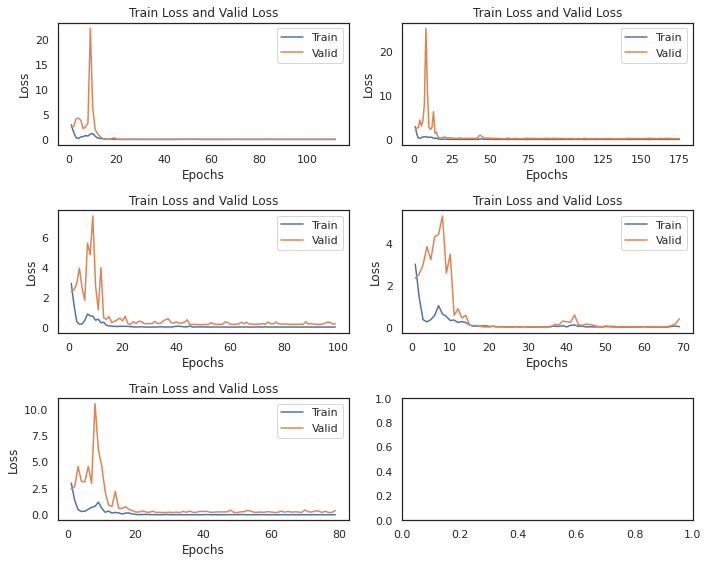

In [104]:
## fold별 epoch당 train loss와 valid loss의 변화
fig ,axs = plt.subplots(3, 2, figsize=(10, 8))
for i, ax in enumerate(axs.flatten()):
    try:
        show_loss_plot(net_epoch_train_loss[i], net_epoch_valid_loss[i], ax)
    except:
        pass
fig.tight_layout()

- MFCC

`-` Mel Spectrogram보다 성능이 낮았다

## test 예측

`-` softmax function을 취하면 10개의 원소 중 최대값의 인덱스 번호가 최종 예측값이 된다

In [105]:
def predict(model: nn.Module, dataloader, weight_save_path, is_prob=False) -> np.array:
    """저장된 모델의 가중치를 불러와서 dataloader의 각 데이터를 예측하여 반환"""
    model = model.to(device) ## device는 전역변수
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), len(target.unique()))) ## test예측값, target은 전역변수

    for weight in weight_path_list :
        model.load_state_dict(torch.load(weight, map_location=device))
        model.eval()
        probs = None
        
        with torch.no_grad(): 
            for test_batch in dataloader:
                test_batch = test_batch.to(device)
                outputs = model(test_batch).cpu().numpy()
                if probs is None:
                    probs = outputs
                else:
                    probs = np.concatenate([probs, outputs])

        test_probs += (probs / N_FOLD) ## N_FOLD는 전역변수
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1) ## 최대값과 인덱스

    if is_prob:
        return test_probs ## 각 컬럼별 확률값
    return test_preds ## 라벨값 

In [106]:
test_dataset = CustomDataset(test_melspec, label_list=None, train_mode=False, transforms=None)  
test_dataloader = DataLoader(test_melspec, batch_size=BATCH_SIZE, shuffle=False)

In [107]:
net = Net().to(device)

In [108]:
preds = predict(net, test_dataloader, SAVE_PATH)

In [111]:
submission['label'] = preds
submission.head()

,file_name,label
0,003.wav,0
1,008.wav,9
2,010.wav,3
3,015.wav,8
4,024.wav,2


In [112]:
submission.to_csv('./Data/submission.csv', index=False)

`-` public score는 $0.99$